# Projeto Dados Strava

## Pegando dados do GPX do Strava

Vamos pegar os dados do percurso da prova LaMision 35km

In [1]:
import gpxpy
import gpxpy.gpx

import pandas as pd
import numpy as np
import haversine as hs
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
with open('La_Mis_on_35km.gpx', 'r', encoding='utf-8') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [3]:
gpx

GPX(tracks=[GPXTrack(name='La Misíon 35km', segments=[GPXTrackSegment(points=[...])])])

In [4]:
gpx.get_track_points_no()

10583

In [5]:
gpx.get_elevation_extremes()

MinimumMaximum(minimum=911.6, maximum=2177.8)

- Aqui temos a altitude menor (altitude_min = 911.6) e o máximo de altitude(altitude_max = 2177.8)

In [6]:
gpx.get_uphill_downhill()

UphillDownhill(uphill=2677.7400000000166, downhill=2686.5400000000154)

- Aqui temos um ganho de elevação de 2677.74m

In [7]:
gpx.tracks[0].segments[0].points[:10]

[GPXTrackPoint(-22.390577, -44.966613, elevation=925.8),
 GPXTrackPoint(-22.390577, -44.966613, elevation=925.8),
 GPXTrackPoint(-22.390577, -44.966613, elevation=926.8),
 GPXTrackPoint(-22.390577, -44.966613, elevation=927.0),
 GPXTrackPoint(-22.390577, -44.966613, elevation=926.8),
 GPXTrackPoint(-22.390577, -44.966613, elevation=926.8),
 GPXTrackPoint(-22.390577, -44.966613, elevation=926.6),
 GPXTrackPoint(-22.390573, -44.96664, elevation=926.4),
 GPXTrackPoint(-22.390573, -44.966668, elevation=926.4),
 GPXTrackPoint(-22.390568, -44.966689, elevation=926.2)]

In [8]:
route_info = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevacao': point.elevation
            })
            
route_df = pd.DataFrame(route_info)
route_df.head(10)

,latitude,longitude,elevacao
0,-22.390577,-44.966613,925.8
1,-22.390577,-44.966613,925.8
2,-22.390577,-44.966613,926.8
3,-22.390577,-44.966613,927.0
4,-22.390577,-44.966613,926.8
5,-22.390577,-44.966613,926.8
6,-22.390577,-44.966613,926.6
7,-22.390573,-44.966640,926.4
8,-22.390573,-44.966668,926.4
9,-22.390568,-44.966689,926.2


- Aqui podemos ver que em nossos dados temos um mesmo lat/long com diferentes 'elevações'. Então vamos agrupar e remover essas linhas

### Removendo linhas e lat/longs duplicados

In [9]:
df = route_df
df['ordem'] = range(len(df))

# Agrupando pela latitude e longitude e calculando a média da elevação
media_elevacao = df.groupby(['latitude', 'longitude'])['elevacao'].mean().reset_index()

# Mesclando os resultados com base na coluna 'ordem' para manter a ordem original das linhas
resultado_final = pd.merge(df[['latitude', 'longitude', 'ordem']], media_elevacao, on=['latitude', 'longitude'], how='left').drop_duplicates().sort_values('ordem').drop(columns='ordem')

df_final = resultado_final.drop_duplicates()
df_final.head()

,latitude,longitude,elevacao
0,-22.390577,-44.966613,926.514286
7,-22.390573,-44.966640,926.400000
8,-22.390573,-44.966668,926.400000
9,-22.390568,-44.966689,926.200000
13,-22.390742,-44.966651,926.000000


In [10]:
df_final.describe()

,latitude,longitude,elevacao
count,10516.000000,10516.000000,10516.000000
mean,-22.403383,-44.931479,1485.066433
std,0.013718,0.015055,395.377434
min,-22.422607,-44.966794,911.600000
25%,-22.418873,-44.945232,1106.550000
50%,-22.400229,-44.930642,1432.300000
75%,-22.391396,-44.917937,1842.850000
max,-22.380947,-44.909437,2177.800000


In [11]:
34440/len(df_final)

3.275009509319133

- aqui podemos observar que nossos dados tem 0516 pontos, e como a rota total tem em média 35Km, dividindo a quantidade de metros total pela quantidade de pontos, temos uma média de em quantos em quantos metros temos informação. No nosso caso, temos em média uma informação a cada 3,27 metros

### Visualização

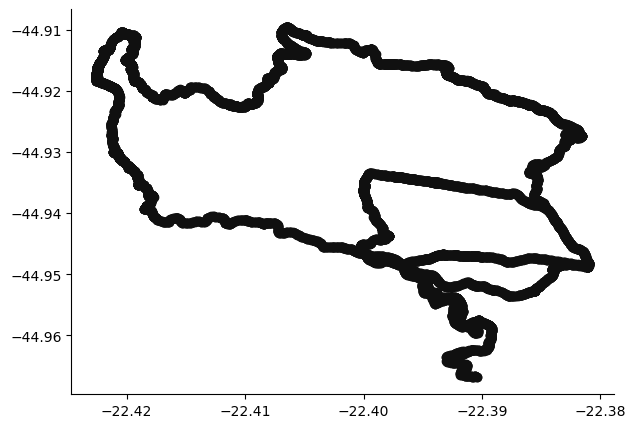

In [12]:
plt.figure(figsize=(7,5))
plt.scatter(df_final['latitude'], df_final['longitude'], color = '#101010')

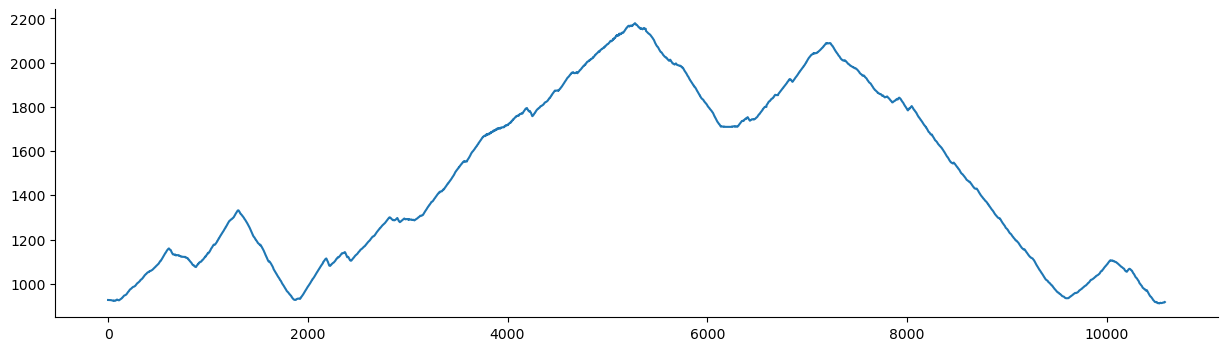

In [13]:
plt.figure(figsize=(15,4))
plt.plot(df_final.index, df_final['elevacao'])

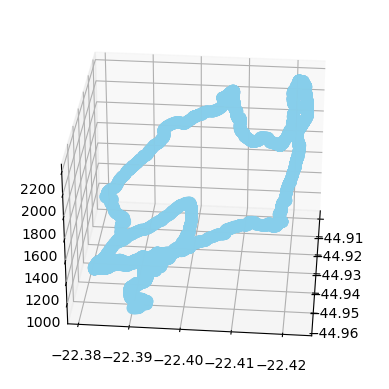

In [29]:
# libraries
from mpl_toolkits.mplot3d import Axes3D


# Dataset
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_final['longitude'],df_final['latitude'],  df_final['elevacao'], c='skyblue', s=60)
ax.view_init(30, 185)
plt.show()

In [47]:
import plotly.graph_objects  as  go 

z=df_final['elevacao']
intensity = (z - z.min()) / (z.max() - z.min())

fig = go.Figure(data=[go.Mesh3d(x=df_final['longitude'],
                                y=df_final['latitude'],
                                z=df_final['elevacao'],
                                intensity=intensity,
                                colorbar_title='Elevação',
                                colorscale='Viridis',  # Você pode escolher qualquer escala de cores
                                showscale=True
                                ),
                                go.Scatter3d(
                                    x=df_final['longitude'],
                                    y=df_final['latitude'],
                                    z=df_final['elevacao'],
                                    mode='lines',
                                    line=dict(color='black', width=4),  # Configurações da linha preta
                                    showlegend=False
                                )
])

fig.update_layout(scene=dict(zaxis=dict(range=[z.min(), z.max()])),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()

### Análises

Calculando a Diferença de elevação entre os Pontos

In [49]:
df_final['diff_elev'] = df_final['elevacao'].diff()
df_final.head()

C:\Users\joaomm\AppData\Local\Temp\ipykernel_22352\3352394021.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,latitude,longitude,elevacao,diff_elev
0,-22.390577,-44.966613,926.514286,NaN
7,-22.390573,-44.966640,926.400000,-0.114286
8,-22.390573,-44.966668,926.400000,0.000000
9,-22.390568,-44.966689,926.200000,-0.200000
13,-22.390742,-44.966651,926.000000,-0.200000


Calculando as distancias entre um ponto e outro

In [50]:
def calc_dist(lat1, long1, lat2, long2) -> float:
    distancia = hs.haversine(
        point1 = (lat1, long1),
        point2 = (lat2, long2),
        unit = hs.Unit.METERS
    )
    return np.round(distancia, 2)

In [51]:
distancia = [np.nan]


for i in range(len(df_final)):
    if i == 0:
        continue
    else:
        distancia.append(calc_dist(
            lat1  = df_final.iloc[i-1]['latitude'],
            long1 = df_final.iloc[i-1]['longitude'],
            lat2  = df_final.iloc[i]['latitude'],
            long2 = df_final.iloc[i]['longitude'],
        ))
    
df_final['distancias'] = distancia


C:\Users\joaomm\AppData\Local\Temp\ipykernel_22352\4016835217.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
df_final.head(10)

,latitude,longitude,elevacao,diff_elev,distancias
0,-22.390577,-44.966613,926.514286,NaN,NaN
7,-22.390573,-44.966640,926.400000,-0.114286,2.81
8,-22.390573,-44.966668,926.400000,0.000000,2.88
9,-22.390568,-44.966689,926.200000,-0.200000,2.23
13,-22.390742,-44.966651,926.000000,-0.200000,19.74
14,-22.390747,-44.966752,926.000000,0.000000,10.40
16,-22.390885,-44.966720,926.200000,0.200000,15.69
17,-22.390925,-44.966702,926.200000,0.000000,4.82
18,-22.391040,-44.966673,926.200000,0.000000,13.13
19,-22.391169,-44.966658,926.000000,-0.200000,14.43


In [53]:
df_final.describe()

,latitude,longitude,elevacao,diff_elev,distancias
count,10516.000000,10516.000000,10516.000000,10515.000000,10515.000000
mean,-22.403383,-44.931479,1485.066433,-0.000905,3.446701
std,0.013718,0.015055,395.377434,0.671920,3.338274
min,-22.422607,-44.966794,911.600000,-9.600000,0.100000
25%,-22.418873,-44.945232,1106.550000,-0.400000,1.170000
50%,-22.400229,-44.930642,1432.300000,0.000000,2.370000
75%,-22.391396,-44.917937,1842.850000,0.400000,4.480000
max,-22.380947,-44.909437,2177.800000,7.600000,22.780000


In [54]:
df_final['distancias'].sum()

36242.06

- Podemos obter que nosso trajeto tem um total de 36,24km

In [57]:
df_final['soma_elev'] = df_final['diff_elev'].cumsum()
df_final['soma_dist'] = df_final['distancias'].cumsum()
df_final = df_final.fillna(0)
df_final.head()


,latitude,longitude,elevacao,diff_elev,distancias,soma_elev,soma_dist
0,-22.390577,-44.966613,926.514286,0.000000,0.00,0.000000,0.00
7,-22.390573,-44.966640,926.400000,-0.114286,2.81,-0.114286,2.81
8,-22.390573,-44.966668,926.400000,0.000000,2.88,-0.114286,5.69
9,-22.390568,-44.966689,926.200000,-0.200000,2.23,-0.314286,7.92
13,-22.390742,-44.966651,926.000000,-0.200000,19.74,-0.514286,27.66


In [58]:
df_final.describe()

,latitude,longitude,elevacao,diff_elev,distancias,soma_elev,soma_dist
count,10516.000000,10516.000000,10516.000000,10516.000000,10516.000000,10516.000000,10516.000000
mean,-22.403383,-44.931479,1485.066433,-0.000905,3.446373,558.552148,18553.656393
std,0.013718,0.015055,395.377434,0.671888,3.338284,395.377434,8964.861367
min,-22.422607,-44.966794,911.600000,-9.600000,0.000000,-14.914286,0.000000
25%,-22.418873,-44.945232,1106.550000,-0.400000,1.170000,180.035714,12383.262500
50%,-22.400229,-44.930642,1432.300000,0.000000,2.370000,505.785714,18550.145000
75%,-22.391396,-44.917937,1842.850000,0.400000,4.480000,916.335714,25429.597500
max,-22.380947,-44.909437,2177.800000,7.600000,22.780000,1251.285714,36242.060000


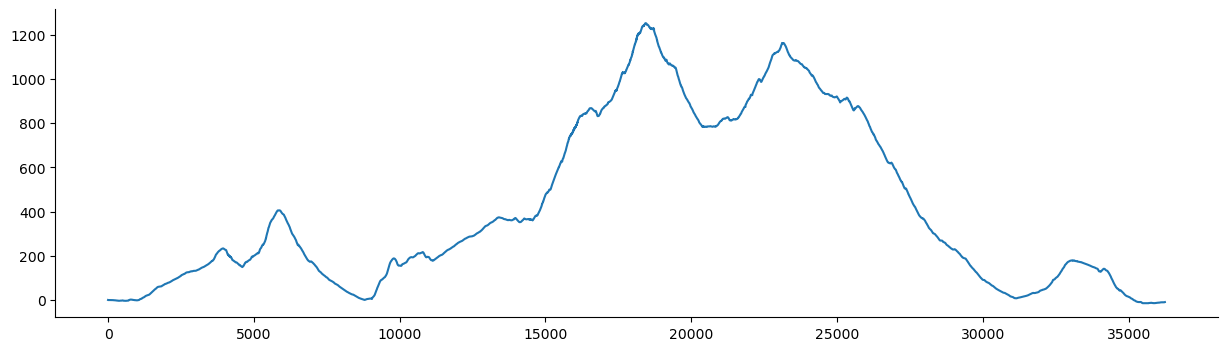

In [59]:
plt.figure(figsize=(15,4))
plt.plot(df_final['soma_dist'], df_final['soma_elev'])

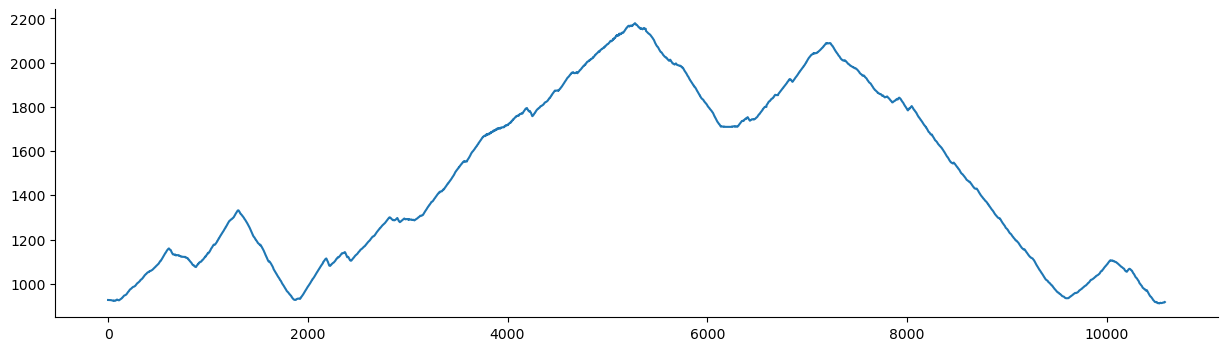

In [64]:
plt.figure(figsize=(15,4))
plt.plot(df_final.index, df_final['elevacao'])